In [2]:
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer, StandardScaler
import matplotlib.pyplot as plt

In [3]:
# Load the JSON data
data_file = 'processed_reactions/all_reactions.json'
with open(data_file, 'r') as file:
    data = json.load(file)

def is_within_deviation(actual_product, expected_product, deviation=0.10):
    if expected_product == 0:
        return actual_product == 0
    return abs(actual_product - expected_product) / abs(expected_product) <= deviation


# Analyze the data
for entry in data:
    r1 = entry['r_values'].get('constant_1')
    r2 = entry['r_values'].get('constant_2')
    r_product = entry.get('r-product')
    
    if r_product is None:
        entry['r-product_filter'] = False
        continue
    
    actual_product = r1 * r2
    
    # Check for division by zero
    if r_product == 0:
        deviation = float('inf') if actual_product != 0 else 0
    else:
        deviation = abs(actual_product - r_product) / abs(r_product)
    
    if is_within_deviation(actual_product, r_product):
        entry['r-product_filter'] = False
    else:
        entry['r-product_filter'] = True # reaction should be filtered out

def filter_conf_intervals(row):
    if 'conf_intervals' in row and 'constant_conf_1' in row['conf_intervals'] and 'constant_conf_2' in row['conf_intervals']:
        conf_1 = row['conf_intervals']['constant_conf_1']
        conf_2 = row['conf_intervals']['constant_conf_2']
        
        # Ensure 'r1' and 'r2' are correctly retrieved from the row
        r1 = row.get('r_values', {}).get('constant_1')
        r2 = row.get('r_values', {}).get('constant_2')
        
        if r1 is not None and r2 is not None and conf_1 is not None and conf_2 is not None:
            # Filter condition: Confidence intervals should not be greater than the corresponding r-values
            return (conf_1 <= 1 * r1) and (conf_2 <= 1 * r2)
    
    # If conditions are not met, return True by default, meaning the row will not be filtered out
    return True

In [4]:
# Convert JSON data to DataFrame
df_full = pd.DataFrame(data)

print('Initial datapoints: ', len(df_full))
df_full = df_full[df_full.apply(filter_conf_intervals, axis=1)]
print('Datapoints after confidence filter:', len(df_full))

# Separate the filtered data
df_filtered = df_full[df_full['r-product_filter'] == False]

print('Datapoints after r-product filter: ', len(df_filtered))

Initial datapoints:  1138
Datapoints after confidence filter: 1060
Datapoints after r-product filter:  1037


In [5]:
import pandas as pd
from rapidfuzz import process, fuzz
from sklearn.impute import SimpleImputer
import numpy as np

# preprocess data
def ensure_list(seq):
    if isinstance(seq, float) and np.isnan(seq):
        return []
    elif not isinstance(seq, list):
        return [seq]
    else:
        return seq

# compute the mean of a list or dictionary values
def compute_mean(value):
    if isinstance(value, dict):
        return np.mean(list(value.values()))
    elif isinstance(value, list):
        return np.mean(value)
    return value

def extract_monomer_features(monomer_data):
    if isinstance(monomer_data, dict):
        return [
            compute_mean(monomer_data.get('ip', None)),
            compute_mean(monomer_data.get('ea', None)),
            compute_mean(monomer_data.get('homo', None)),
            compute_mean(monomer_data.get('lumo', None)),
            compute_mean(monomer_data.get('global_electrophilicity', None)),
            compute_mean(monomer_data.get('global_nucleophilicity', None)),
            compute_mean(monomer_data.get('charges', None)),
            compute_mean(monomer_data.get('dipole', None)),
            compute_mean(monomer_data.get('fukui_radical', None))
        ]
    else:
        return None


def preprocess_data(df, target_column):
    # Add r1, r2, and r1r2 columns
    df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
    df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
    df['r1r2'] = df['r1'] * df['r2']

    # Filter out rows with NaNs in monomer1, monomer2, or r1r2
    df.dropna(subset=['monomer1', 'monomer2', 'r1r2'], inplace=True)
    
    # Filter out rows where solvent is NaN and method is not 'bulk'
    df = df[~((df['solvent'].isna()) & (df['method'] != 'bulk'))]
    
    print(f"Datapoints after removing None values: {len(df)}")
    
    method_mapping = {
    'bulk': 0,
    'Bulk': 0,
    'solvent': 1,
    'Solvent': 1,
    'emulsion': 2,
    'suspension': 3,
    'photopolymerization': 10
    }
    
    # Create a mapping for the grouped calculation methods
    calculation_method_mapping = {
        'Kelen-Tudor': 0,
        'Fineman-Ross': 1,
        'Fineman and Ross': 1,
        'Fineman Ross method': 1,
        'fundamental equation of copolymerisation': 2,
        'Mayo and Lewis': 3,
        'Mayo-Lewis differential method': 3,
        'Mayo and Lewis method': 3,
        'Mayo and Lewis intersection method': 3,
        'Intersection method': 3,
        'intersection method of Mayo and Lewis': 3,
        'Joshi-Joshi': 4,
        'Schwan and Price': 5,
        'Alfrey-Price': 6,
        'Alfrey and Goldfinger': 6,
        'regression analysis': 7,
        'nonlinear least squares technique': 7,
        'non-linear regression': 7,
        'nonlinear least squares': 7,
        'nonlinear least squares analysis': 7,
        'nonlinear least squares procedure': 7,
        'approximations successives': 7,
        'graphical solution of the copolymerization equation': 8,
        'graphical method of intersections': 8,
        'graphical evaluation': 8,
        'graphical': 8,
        'graphic method': 8,
        'graphic solution': 8,
        'logarithm plot': 9,
        'polarization': 10,
        'Nuclear magnetic resonance spectroscopy': 11,
        'NMR spectroscopy': 11,
        'NMR analysis': 11,
        'carbon elemental analyses': 12,
        'nitrogen analyses': 13,
        'Ghosh-Palit': 14,
        'curve fitting': 15,
        'curve-fitting technique': 15,
        'curve-fitting': 15,
        'Multiparameter correlation equation': 16,
        'Yserielve-Brokhina-Roskin': 17,
        'Yezrielev method': 17,
        'Ezrievlev and co-workers': 17,
        'Shtraikhman approach': 18,
        'differential form of the copolymer equation': 19,
        'penultimate model': 20,
        'penultimate mu model': 20,
        'Alfrey-Price equation': 21,
        'assumed': 22,
        'Optimizer': 23,
        'Barb': 24,
        'previous paper': 30,
        'not provided': 30,
        'not specified': 30,
        'EVM Program': 27,
        'Tidwell-Mortimer': 28,
        'Grant': 29,
        'null': 30
    }

    # Apply the custom mapping
    df['calculation_method_encoded'] = df['calculation_method'].map(calculation_method_mapping)
    
    # Label-Encoding for 'method'
    df['method_encoded'] = df['method'].map(method_mapping)
    
    print('method', df['method_encoded'].unique())
    print('calc method',df['calculation_method_encoded'].unique())

    
    df['monomer1_features'] = df['monomer1_data'].apply(extract_monomer_features)
    df['monomer2_features'] = df['monomer2_data'].apply(extract_monomer_features)

    # Drop rows with any missing monomer features
    df.dropna(subset=['monomer1_features', 'monomer2_features'], inplace=True)

    df['solvent_logP'] = df['logP'].fillna(0)

    # Remove rows that contain NaN values in the target variable
    df.dropna(subset=[target_column], inplace=True)
    
    # Create a flipped version of the dataframe with monomer1 and monomer2 data swapped
    df_flipped = df.copy()
    df_flipped['monomer1'], df_flipped['monomer2'] = df['monomer2'], df['monomer1']
    df_flipped['monomer1_features'], df_flipped['monomer2_features'] = df['monomer2_features'], df['monomer1_features']
    
    # Combine the original and flipped dataframes
    df = pd.concat([df, df_flipped], ignore_index=True)


    # Combine monomer features and solvent logP into a feature matrix
    monomer1_features = np.vstack(df['monomer1_features'].values)
    monomer2_features = np.vstack(df['monomer2_features'].values)
    solvent_logP = df['solvent_logP'].values.reshape(-1, 1)
    temperature = df['temperature'].values.reshape(-1, 1)
    method_features = df['method_encoded'].values.reshape(-1, 1)
    calculation_method_features = df['calculation_method_encoded'].values.reshape(-1, 1)

    # Combine all features into a single array
    all_features = np.hstack([monomer1_features, monomer2_features, solvent_logP, temperature, method_features, calculation_method_features])

    # Handle any remaining NaN values by imputing them with the column mean
    imputer = SimpleImputer(strategy='mean')
    all_features = imputer.fit_transform(all_features)
    
    # Normalization step
    scaler = StandardScaler()
    all_features = scaler.fit_transform(all_features)

    # Define the feature names based on the actual keys
    monomer1_keys = ['ip', 'ea', 'homo', 'lumo', 'global_electrophilicity', 'global_nucleophilicity', 'charges', 'dipole', 'fukui_radical']
    monomer2_keys = ['ip', 'ea', 'homo', 'lumo' ,'global_electrophilicity', 'global_nucleophilicity', 'charges', 'dipole', 'fukui_radical']

    feature_names = (
        [f'monomer1_{key}' for key in monomer1_keys] +
        [f'monomer2_{key}' for key in monomer2_keys] +
        ['solvent_logP', 'temperature', 'method_encoded', 'calculation_method_encoded']
    )

    # Continuous target variable for regression
    regression_labels = df[target_column].values

    return all_features, regression_labels, feature_names

def calculate_r_product(df):
    df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
    df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
    df['r1r2'] = df['r1'] * df['r2']
    return df

# Example usage
# Assuming df_filtered is your DataFrame with all the required columns
df_filtered = calculate_r_product(df_filtered)

all_features, regression_labels, feature_names = preprocess_data(df_filtered, 'r1r2')


Datapoints after removing None values: 1002
method [ 1  0  2  3 10]
calc method [ 0. nan  1.  2.  3.  5. 12. 13.  6.  7.  4. 23.  8.  9. 30. 10. 11. 27.
 22. 14. 15. 17. 19. 20. 24. 16. 18. 28. 29. 21.]


/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_91960/3445391452.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_91960/3445391452.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
/var/folders/tv/b0y73fwd

Datapoints after removing None values: 1002
method [ 1  0  2  3 10]
calc method [ 0. nan  1.  2.  3.  5. 12. 13.  6.  7.  4. 23.  8.  9. 30. 10. 11. 27.
 22. 14. 15. 17. 19. 20. 24. 16. 18. 28. 29. 21.]


/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_91960/68357554.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_91960/68357554.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
/var/folders/tv/b0y73fwd4zn44s

Anzahl der Feature-Namen: 22
Anzahl der Koeffizienten: 22
Target: r1r2
Average Training MSE: 90.3196, Average Training R2: 0.0195
Average Test MSE: 92.2102, Average Test R2: -0.0010
Best parameters from Grid Search: {'feature_selector__kw_args': {'indices': [6, 7, 8, 9, 10, 11]}, 'ridge__alpha': 100.0, 'ridge__solver': 'svd'}
Average Feature Coefficients:
monomer1_ip: -0.0336
monomer1_ea: 0.5372
monomer1_homo: 0.1949
monomer1_lumo: 0.3528
monomer1_global_electrophilicity: 0.0487
monomer1_global_nucleophilicity: 0.0336
monomer1_charges: -0.0351
monomer1_dipole: 0.1566
monomer1_fukui_radical: 0.0570
monomer2_ip: -0.3085
monomer2_ea: -0.0199
monomer2_homo: -0.2671
monomer2_lumo: 0.0045
monomer2_global_electrophilicity: -0.1279
monomer2_global_nucleophilicity: 0.3085
monomer2_charges: 0.1308
monomer2_dipole: -0.4573
monomer2_fukui_radical: 0.5042
solvent_logP: 0.6825
temperature: 0.1976
method_encoded: -0.4679
calculation_method_encoded: -0.0614


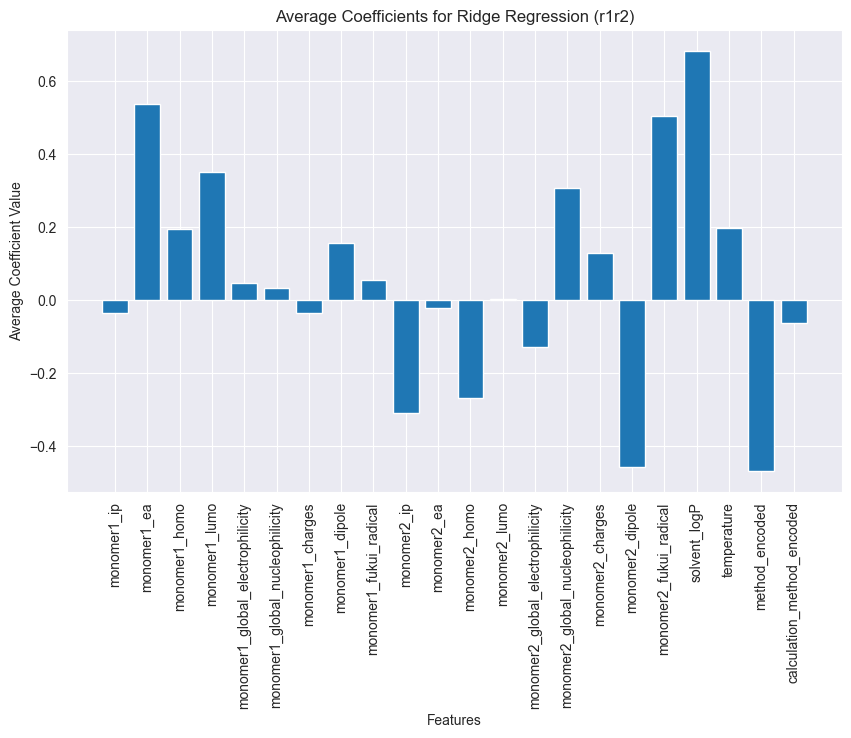

Best model saved as best_ridge_model_r1r2.pkl


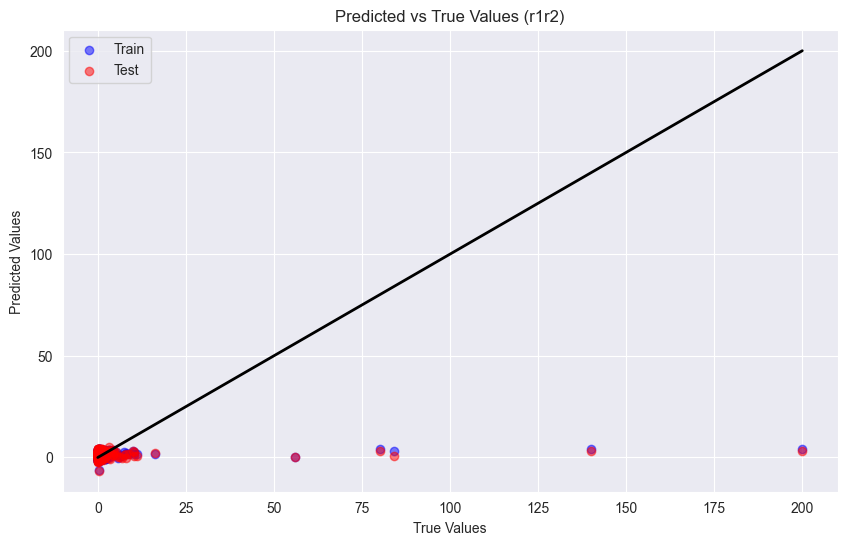

/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_91960/3445391452.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_91960/3445391452.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
/var/folders/tv/b0y73fwd4z

Datapoints after removing None values: 1002
method [ 1  0  2  3 10]
calc method [ 0. nan  1.  2.  3.  5. 12. 13.  6.  7.  4. 23.  8.  9. 30. 10. 11. 27.
 22. 14. 15. 17. 19. 20. 24. 16. 18. 28. 29. 21.]
Anzahl der Feature-Namen: 22
Anzahl der Koeffizienten: 22
Target: r1r2_sqrt
Average Training MSE: 0.8009, Average Training R2: 0.0338
Average Test MSE: 0.8293, Average Test R2: -0.0004
Best parameters from Grid Search: {'feature_selector__kw_args': {'indices': [0, 1, 2, 3, 4, 5]}, 'ridge__alpha': 100.0, 'ridge__solver': 'saga'}
Average Feature Coefficients:
monomer1_ip: -0.0184
monomer1_ea: 0.0240
monomer1_homo: -0.0283
monomer1_lumo: -0.0182
monomer1_global_electrophilicity: -0.0179
monomer1_global_nucleophilicity: 0.0184
monomer1_charges: -0.0004
monomer1_dipole: 0.0158
monomer1_fukui_radical: -0.0175
monomer2_ip: -0.0451
monomer2_ea: -0.0541
monomer2_homo: -0.1080
monomer2_lumo: -0.0260
monomer2_global_electrophilicity: -0.0363
monomer2_global_nucleophilicity: 0.0451
monomer2_charges

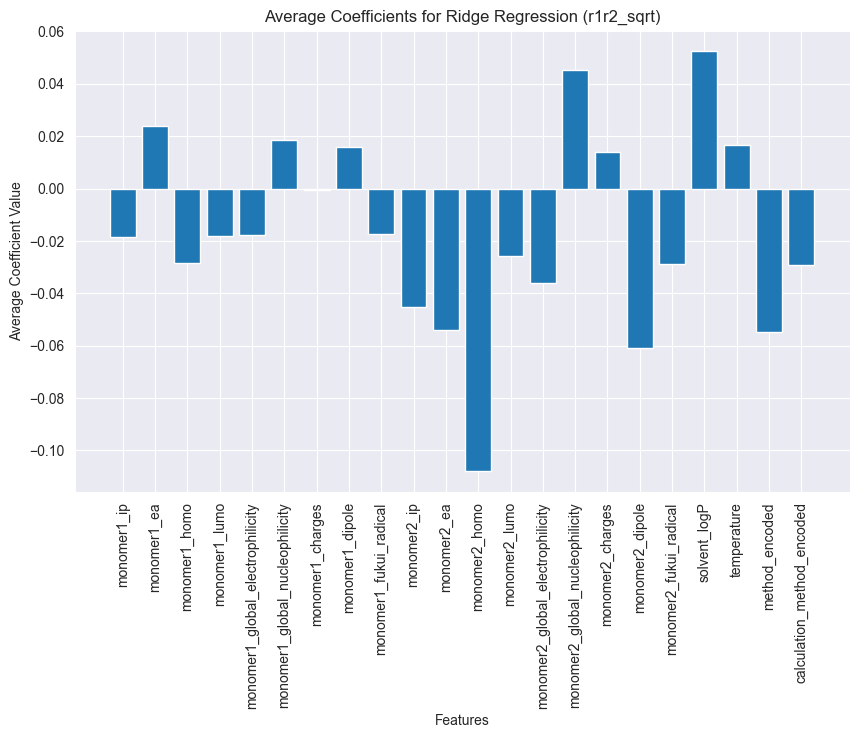

Best model saved as best_ridge_model_r1r2_sqrt.pkl


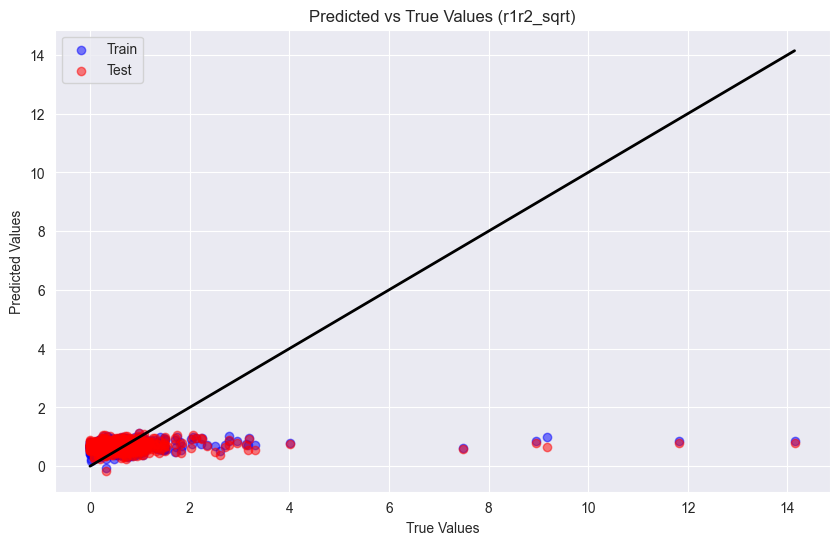

Datapoints after removing None values: 1002
method [ 1  0  2  3 10]
calc method [ 0. nan  1.  2.  3.  5. 12. 13.  6.  7.  4. 23.  8.  9. 30. 10. 11. 27.
 22. 14. 15. 17. 19. 20. 24. 16. 18. 28. 29. 21.]


/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_91960/3445391452.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_91960/3445391452.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
/var/folders/tv/b0y73fwd4z

Anzahl der Feature-Namen: 22
Anzahl der Koeffizienten: 22
Target: r1r2_log
Average Training MSE: 0.2492, Average Training R2: 0.0507
Average Test MSE: 0.2605, Average Test R2: 0.0079
Best parameters from Grid Search: {'feature_selector__kw_args': {'indices': [0, 1, 2, 3, 4, 5]}, 'ridge__alpha': 100.0, 'ridge__solver': 'saga'}
Average Feature Coefficients:
monomer1_ip: -0.0120
monomer1_ea: -0.0002
monomer1_homo: -0.0271
monomer1_lumo: -0.0278
monomer1_global_electrophilicity: -0.0152
monomer1_global_nucleophilicity: 0.0120
monomer1_charges: 0.0034
monomer1_dipole: 0.0072
monomer1_fukui_radical: -0.0153
monomer2_ip: -0.0282
monomer2_ea: -0.0486
monomer2_homo: -0.0861
monomer2_lumo: -0.0251
monomer2_global_electrophilicity: -0.0265
monomer2_global_nucleophilicity: 0.0282
monomer2_charges: 0.0064
monomer2_dipole: -0.0366
monomer2_fukui_radical: -0.0369
solvent_logP: 0.0275
temperature: -0.0015
method_encoded: -0.0340
calculation_method_encoded: -0.0238


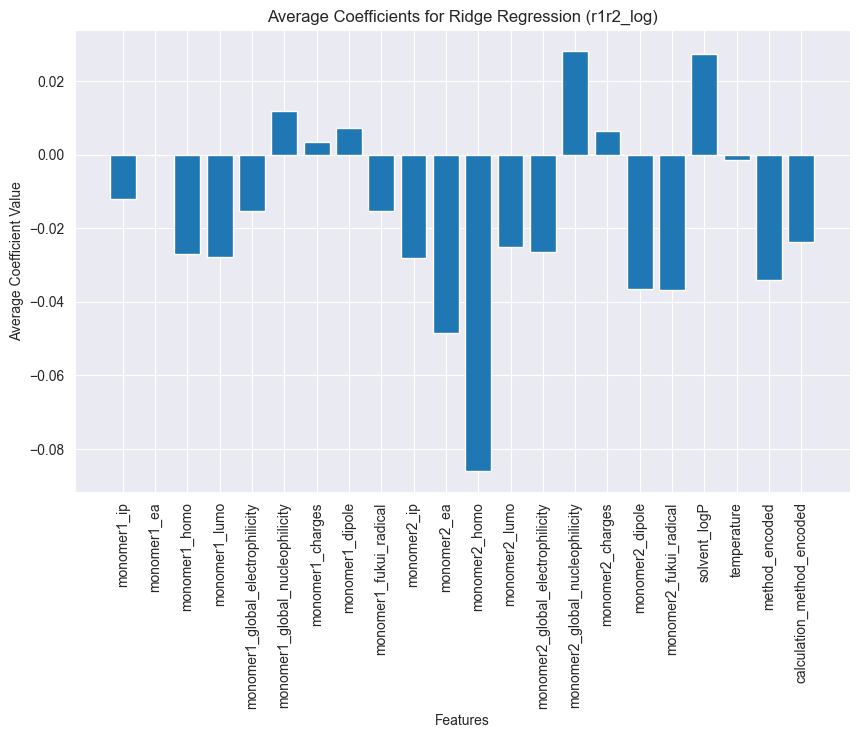

Best model saved as best_ridge_model_r1r2_log.pkl


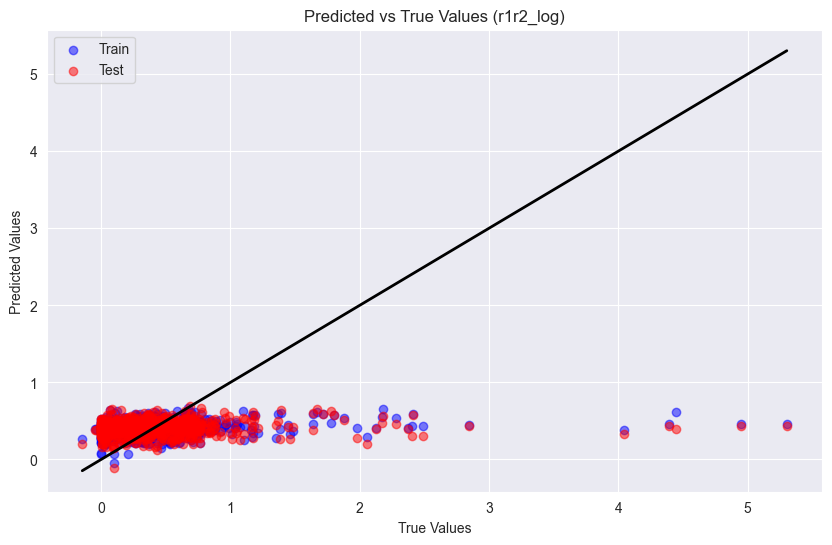

Datapoints after removing None values: 1002
method [ 1  0  2  3 10]
calc method [ 0. nan  1.  2.  3.  5. 12. 13.  6.  7.  4. 23.  8.  9. 30. 10. 11. 27.
 22. 14. 15. 17. 19. 20. 24. 16. 18. 28. 29. 21.]


/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_91960/3445391452.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_91960/3445391452.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
/var/folders/tv/b0y73fwd4z

KeyboardInterrupt: 

In [6]:
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Function to apply Power Transformation
def power_transform(column):
    pt = PowerTransformer(method='yeo-johnson')
    transformed = pt.fit_transform(column.values.reshape(-1, 1))
    return transformed.flatten()

def preprocess_data_with_transformations(df):
    # Transform r1r2 values
    df['r1r2_sqrt'] = np.sqrt(df['r1r2'])
    df['r1r2_log'] = np.log1p(df['r1r2'])
    df['r1r2_power'] = power_transform(df['r1r2'])
    
    return df

def calculate_r_product(df):
    df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
    df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
    df['r1r2'] = df['r1'] * df['r2']
    return df

# Function to select features, moved outside the main function to avoid PicklingError
def select_features(X, indices):
    return X[:, indices]

# Calculate r1r2
df_filtered = calculate_r_product(df_filtered)
# Apply transformations
df_transformed = preprocess_data_with_transformations(df_filtered)

# Funktion zum Trainieren, Bewerten und Optimieren des Ridge-Regressionsmodells
def train_evaluate_optimize(df, target_column, n_repeats=10):
    all_train_mse = []
    all_test_mse = []
    all_train_r2 = []
    all_test_r2 = []
    all_coefficients = []

    # Preprocess the data once
    all_features, regression_labels, feature_names = preprocess_data(df, target_column)

    # Splitting the data into training and testing sets (50% split for example)
    train_size = int(0.5 * len(all_features))
    train_all_features = all_features[:train_size]
    test_all_features = all_features[train_size:]
    train_regression_labels = regression_labels[:train_size]
    test_regression_labels = regression_labels[train_size:]

    # Define different feature subsets
    feature_subsets = [
        list(range(all_features.shape[1])),  # All features
        [0, 1, 2, 3, 4, 5],  # Subset 1
        [6, 7, 8, 9, 10, 11],  # Subset 2
        [0, 1, 6, 7]  # Combination of some features from both subsets
    ]

    # Create a pipeline with feature selection and Ridge regression
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),  # Optionally standardize the features
        ('feature_selector', FunctionTransformer(select_features)),  # Feature selection step
        ('ridge', Ridge())  # Ridge regression model
    ])

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'ridge__alpha': [0.1, 1.0, 10.0, 100.0],  # Different alpha values to try
        'ridge__solver': ['auto', 'svd', 'cholesky', 'saga'],  # Different solvers to test
        'feature_selector__kw_args': [{'indices': subset} for subset in feature_subsets]  # Feature subsets to test
    }

    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(train_all_features, train_regression_labels)

    # Retrieve the best model from the grid search
    best_model = grid_search.best_estimator_

    # Initialize best_test_r2 with a very low value
    best_test_r2 = -np.inf

    # Evaluate the best model multiple times
    best_train_predictions = None
    best_test_predictions = None
    for _ in range(n_repeats):
        ridge_model = best_model.named_steps['ridge']
        ridge_model.fit(train_all_features, train_regression_labels)

        # Store the coefficients
        all_coefficients.append(ridge_model.coef_)

        train_predictions = ridge_model.predict(train_all_features)
        test_predictions = ridge_model.predict(test_all_features)

        train_mse = mean_squared_error(train_regression_labels, train_predictions)
        test_mse = mean_squared_error(test_regression_labels, test_predictions)
        train_r2 = r2_score(train_regression_labels, train_predictions)
        test_r2 = r2_score(test_regression_labels, test_predictions)

        all_train_mse.append(train_mse)
        all_test_mse.append(test_mse)
        all_train_r2.append(train_r2)
        all_test_r2.append(test_r2)

        # Store predictions of the best model
        if test_r2 > best_test_r2:
            best_test_r2 = test_r2
            best_train_predictions = train_predictions
            best_test_predictions = test_predictions

    avg_train_mse = np.mean(all_train_mse)
    avg_test_mse = np.mean(all_test_mse)
    avg_train_r2 = np.mean(all_train_r2)
    avg_test_r2 = np.mean(all_test_r2)

    avg_coefficients = np.mean(all_coefficients, axis=0)

    # Überprüfe die Länge der Listen
    print(f"Anzahl der Feature-Namen: {len(feature_names)}")
    print(f"Anzahl der Koeffizienten: {len(avg_coefficients)}")

    if len(feature_names) != len(avg_coefficients):
        print("Fehler: Die Anzahl der Feature-Namen stimmt nicht mit der Anzahl der Koeffizienten überein.")
        return

    print(f'Target: {target_column}')
    print(f'Average Training MSE: {avg_train_mse:.4f}, Average Training R2: {avg_train_r2:.4f}')
    print(f'Average Test MSE: {avg_test_mse:.4f}, Average Test R2: {avg_test_r2:.4f}')
    print(f'Best parameters from Grid Search: {grid_search.best_params_}')
    print(f'Average Feature Coefficients:')
    for name, coef in zip(feature_names, avg_coefficients):
        print(f'{name}: {coef:.4f}')

    # Optionally plot the average coefficients
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, avg_coefficients)
    plt.xlabel('Features')
    plt.ylabel('Average Coefficient Value')
    plt.title(f'Average Coefficients for Ridge Regression ({target_column})')
    plt.xticks(rotation=90)
    plt.show()

    # Speichern des besten Modells
    model_filename = f'best_ridge_model_{target_column}.pkl'
    joblib.dump(best_model, model_filename)
    print(f'Best model saved as {model_filename}')

    # Plot der vorhergesagten gegen die tatsächlichen Werte
    plt.figure(figsize=(10, 6))
    plt.scatter(train_regression_labels, best_train_predictions, color='blue', alpha=0.5, label='Train')
    plt.scatter(test_regression_labels, best_test_predictions, color='red', alpha=0.5, label='Test')
    plt.plot([min(train_regression_labels), max(train_regression_labels)], [min(train_regression_labels), max(train_regression_labels)], color='black', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs True Values ({target_column})')
    plt.legend()
    plt.show()

# Example usage for different transformations
train_evaluate_optimize(df_transformed, 'r1r2')
train_evaluate_optimize(df_transformed, 'r1r2_sqrt')
train_evaluate_optimize(df_transformed, 'r1r2_log')
train_evaluate_optimize(df_transformed, 'r1r2_power')


In [ ]:
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import random

def get_normalized_importance(importances):
    total = sum(importances.values())
    return {key: val / total for key, val in importances.items()}

def combine_importances(weight_importance, gain_importance, cover_importance, feature_names):
    weight_importance = get_normalized_importance(weight_importance)
    gain_importance = get_normalized_importance(gain_importance)
    cover_importance = get_normalized_importance(cover_importance)
    
    combined_importance = {}
    
    for key in weight_importance.keys():
        combined_importance[key] = (
            weight_importance.get(key, 0) +
            gain_importance.get(key, 0) +
            cover_importance.get(key, 0)
        ) / 3  
    
    sorted_importance = sorted(combined_importance.items(), key=lambda x: x[1], reverse=True)
    sorted_features = [feature_names[int(key[1:])] for key, _ in sorted_importance]
    sorted_scores = [score for _, score in sorted_importance]
    
    return sorted_features, sorted_scores

def plot_feature_importance(sorted_features, sorted_scores):
    plt.figure(figsize=(10, 8))
    plt.barh(sorted_features, sorted_scores, color='skyblue')
    plt.xlabel('Combined Importance Score')
    plt.title('Overall Feature Importance')
    plt.gca().invert_yaxis()
    plt.savefig('combined_feature_importance.png', bbox_inches='tight', dpi=300)
    plt.show()

def plot_transformed_data(original_labels, transformed_labels, transformation_name):
    plt.figure(figsize=(8, 6))
    plt.hist(transformed_labels, bins=50, alpha=0.5, label=transformation_name)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(f'{transformation_name} Transformation')
    plt.legend()
    plt.show()

def plot_prediction(train_regression_labels, best_train_predictions, test_regression_labels, best_test_predictions):
    # Select 100 random samples from training and 50 from testing
    train_indices = random.sample(range(len(train_regression_labels)), 100)
    test_indices = random.sample(range(len(test_regression_labels)), 50)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(np.array(train_regression_labels)[train_indices], np.array(best_train_predictions)[train_indices], color='blue', alpha=0.5, label='Train')
    plt.scatter(np.array(test_regression_labels)[test_indices], np.array(best_test_predictions)[test_indices], color='red', alpha=0.5, label='Test')
    plt.plot([min(train_regression_labels), max(train_regression_labels)], [min(train_regression_labels), max(train_regression_labels)], color='black', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs True Values')
    plt.legend()
    plt.show()

def train_evaluate_weighted_xgb(all_features, regression_labels, sample_weights, feature_names, transformation_name):
    # Split the data (including sample_weights)
    train_all_features, test_all_features, train_regression_labels, test_regression_labels, train_weights, test_weights = train_test_split(
        all_features, regression_labels, sample_weights, test_size=0.2, random_state=42
    )
    
    print(f'test: {len(test_all_features)}, train: {len(train_all_features)}')

    # Define the XGBoost model
    xgb_model = XGBRegressor()

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [1000, 2000],
        'learning_rate': [0.1, 0.3],
        'max_depth': [10, 20],
        'min_child_weight': [3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8],
        'gamma': [0]
    }

    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
    grid_search.fit(train_all_features, train_regression_labels, sample_weight=train_weights)

    best_model = grid_search.best_estimator_
    print(f"Best parameters for {transformation_name} found: ", grid_search.best_params_)
    print(f"Best MAE score during cross-validation for {transformation_name}: ", grid_search.best_score_)

    weight_importance = best_model.get_booster().get_score(importance_type='weight')
    gain_importance = best_model.get_booster().get_score(importance_type='gain')
    cover_importance = best_model.get_booster().get_score(importance_type='cover')

    sorted_features, sorted_scores = combine_importances(weight_importance, gain_importance, cover_importance, feature_names)
    
    plot_feature_importance(sorted_features, sorted_scores)

    train_predictions = best_model.predict(train_all_features)
    test_predictions = best_model.predict(test_all_features)
    
    plot_prediction(train_regression_labels, train_predictions, test_regression_labels, test_predictions)

    train_mse = mean_squared_error(train_regression_labels, train_predictions)
    test_mse = mean_squared_error(test_regression_labels, test_predictions)
    test_mae = mean_absolute_error(test_regression_labels, test_predictions)
    train_r2 = r2_score(train_regression_labels, train_predictions)
    test_r2 = r2_score(test_regression_labels, test_predictions)

    print(f'{transformation_name} - Average Training MSE: {train_mse:.4f}, Average Training R2: {train_r2:.4f}')
    print(f'{transformation_name} - Average Test MSE: {test_mse:.4f}, Average Test R2: {test_r2:.4f}, Average MAE: {test_mae:.4f}')

    return test_mse, test_r2, test_mae

# Main function to apply the Power Transformation and train
def apply_transformations_and_train(df, target_column):
    # Preprocess the data first to get all_features and sample_weights
    all_features, regression_labels, feature_names = preprocess_data(df, target_column)

    # Power transformation (Yeo-Johnson)
    print(f"\nPower Transformation:")
    power_transformer = PowerTransformer(method='yeo-johnson')
    power_labels = power_transformer.fit_transform(regression_labels.reshape(-1, 1)).flatten()
    plot_transformed_data(regression_labels, power_labels, "Power")
    sample_weights = np.abs(power_labels) + 1e-3  # Adjust sample weights based on the transformed labels
    train_evaluate_weighted_xgb(all_features, power_labels, sample_weights, feature_names, "Power Transformation")

# Call the main function to perform the analysis
apply_transformations_and_train(df_filtered, 'r1r2')


/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_91960/2171465496.py:10: RuntimeWarning: invalid value encountered in sqrt
  sqrt_labels = np.sqrt(original_labels)


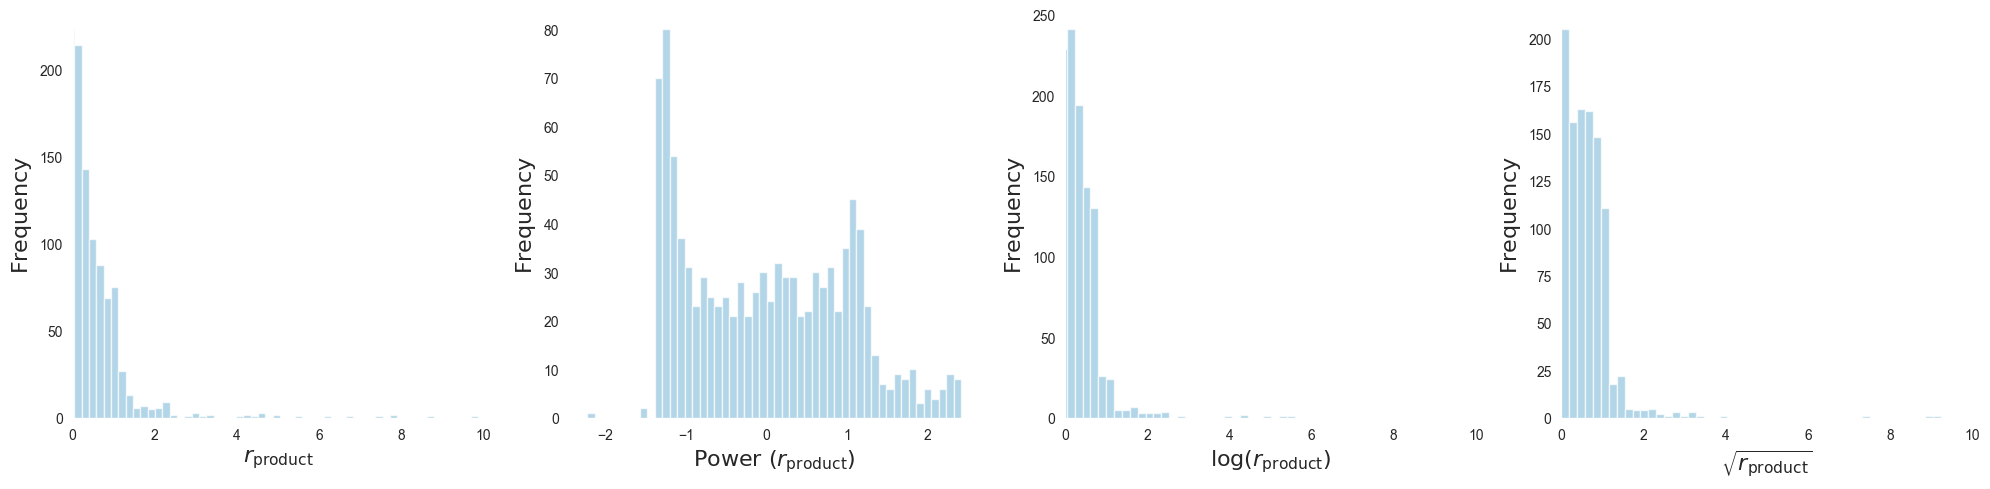

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PowerTransformer

def plot_transformed_data_combined(original_labels):
    # Apply different transformations
    power_transformer = PowerTransformer(method='yeo-johnson')
    power_labels = power_transformer.fit_transform(original_labels.reshape(-1, 1)).flatten()
    log_labels = np.log1p(original_labels)
    sqrt_labels = np.sqrt(original_labels)
    
    # Create a 1x4 subplot for the different transformations
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original
    axes[0].hist(original_labels, bins=1500, color='#92C4DE', alpha=0.7)
    axes[0].set_xlabel(r'$r_{\text{product}}$', fontsize=16)
    axes[0].set_ylabel(r'$\text{Frequency}$', fontsize=16)
    axes[0].set_xlim(0, 10)
    
    # Power Transformation
    axes[1].hist(power_labels, bins=50, color='#92C4DE', alpha=0.7)
    axes[1].set_xlabel(r'$\text{Power } (r_{\text{product}})$', fontsize=16)
    axes[1].set_ylabel(r'$\text{Frequency}$', fontsize=16)
    
    # Log Transformation
    axes[2].hist(log_labels, bins=30, color='#92C4DE', alpha=0.7)
    axes[2].set_xlabel(r'$\log(r_{\text{product}})$', fontsize=16)
    axes[2].set_ylabel(r'$\text{Frequency}$', fontsize=16)
    axes[2].set_xlim(0, 10)
    
    # Square Root Transformation
    axes[3].hist(sqrt_labels, bins=85, color='#92C4DE', alpha=0.7)
    axes[3].set_xlabel(r'$\sqrt{r_{\text{product}}}$', fontsize=16)
    axes[3].set_ylabel(r'$\text{Frequency}$', fontsize=16)
    axes[3].set_xlim(0, 10)
    
    for ax in axes:
        ax.grid(False)
        ax.set_facecolor('white')
    
    plt.gcf().set_facecolor('white')
    plt.tight_layout()
    
    plt.savefig('combined_transformations.pdf', dpi=300)
    plt.show()

plot_transformed_data_combined(df_filtered['r1r2'].values)
